In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("fivethirtyeight")

from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.pipeline import Pipeline

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import trange

from utils import get_label, get_multi_label, plot_roc, evaluate, Imputer, Vectorizer, Splitter
from models import WeightedLogisticRegression

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
data = pd.read_csv("data/train.tsv", sep="\t")
x_train, x_test, y_train_multi, y_test_multi = train_test_split(data.drop("label", axis=1), get_multi_label(data), random_state=RANDOM_SEED)
y_train = torch.tensor([1 if y == 0 else 0 for y in y_train_multi]).float()
y_test = torch.tensor(np.array([1 if y == 0 else 0 for y in y_test_multi])).float()

from scipy.sparse.csr import csr_matrix

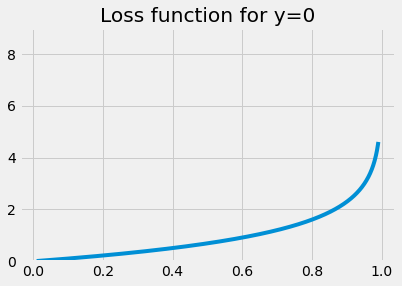

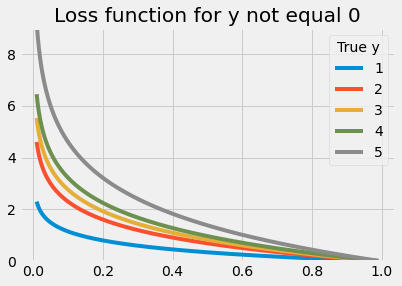

In [6]:
y_pred = np.linspace(0.01, 0.99, 1000)
loss_0 = -np.log(1 - y_pred)
plt.plot(y_pred, loss_0)
plt.title("Loss function for y=0")
plt.ylim((0, 9))
plt.show()

loss_base = -np.log(y_pred)
loss_1 = 0.5 * loss_base
loss_2 = loss_base
loss_3 = 1.2 * loss_base
loss_4 = 1.4*loss_base
loss_5 = 2*loss_base
plt.plot(y_pred, loss_1, label="1")
plt.plot(y_pred, loss_2, label="2")
plt.plot(y_pred, loss_3, label="3")
plt.plot(y_pred, loss_4, label="4")
plt.plot(y_pred, loss_5, label="5")
plt.ylim((0, 9))
plt.title("Loss function for y not equal 0")
plt.legend(title="True y");

Accuracy: 91.23
F-1 score: 0.1379


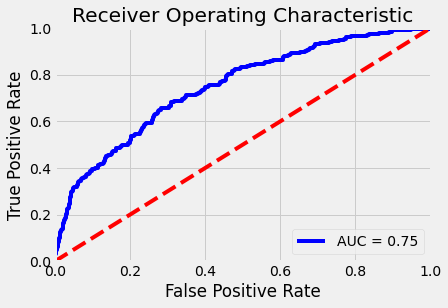

In [33]:
impute_vectorize = Pipeline([
    ("imputer", Imputer), ("vectorizer", Vectorizer)
])

split_vectorize = Pipeline([
    ("splitter", Splitter), ("vectorizer", Vectorizer)
])

column_transformer = ColumnTransformer([
       ("statement_vectorizer", Vectorizer ,"statement"),
        ("subject_vectorizer", split_vectorize, "subject"),
        ("job", impute_vectorize, "speaker_job"),
        ("state", impute_vectorize, "state"),
        ("party", impute_vectorize, "party"),
        ("context", impute_vectorize, "context")
    ])


pipeline = Pipeline([
    ("get_features", column_transformer),
    ("predict", WeightedLogisticRegression(lr=0.1, weight_decay=0.00005, max_iter=1000, tol=1e-6))
])

pipeline.fit(x_train, y_train_multi);
evaluate(pipeline, x_test, y_test)